In [ ]:
# Import Packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import shutil

In [ ]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.12.1+cu113


In [ ]:
# Mount to drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/ML-Final-Project/") # Remember to add this shared folder as shortcut to your own google drive
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/ML-Final-Project'

In [ ]:
# Copied from https://www.kaggle.com/code/androbomb/using-cnn-to-classify-images-w-pytorch

def load_dataset(data_path):
    import torch
    import torchvision
    import torchvision.transforms as transforms
    # Load all the images
    transformation = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        # transforms.RandomCrop((128,128))
        transforms.CenterCrop((512,512))
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=128,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=128,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


In [ ]:
# Recall that we have resized the images and saved them into
train_folder = 'whole-1000/'

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size
print("Data loaders ready to read", train_folder)

Data loaders ready to read whole-1000/


In [ ]:
# The images are in a folder named 'input/natural-images/natural_images'
training_folder_name = 'whole-1000/'

# All images are 128x128 pixels
img_size = (512,512)

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

['drawing', 'painting', 'photograph', 'photomechanical print']


In [ ]:
# Model

# Create a neural net class
class Net(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # In the init function, we define each layer we will use in our model
        
        # Our images are RGB, so we have input channels = 3. 
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # This means that our feature tensors are now 32 x 32, and we've generated 24 of them
        
        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=64 * 64 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        x = F.relu(self.pool(self.conv1(x))) 
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv2(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv3(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        # Flatten
        x = x.view(-1, 64 * 64 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=98304, out_features=4, bias=True)
)


In [ ]:
len(train_loader)

24

In [ ]:
# Train Model

def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [ ]:
# Test Model

def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [ ]:
model = Net(num_classes=len(classes)).to(device)

print(model)

# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 10
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=98304, out_features=4, bias=True)
)
Training on cuda
Epoch: 1
	Training batch 1 Loss: 1.385753
	Training batch 2 Loss: 17.101162
	Training batch 3 Loss: 7.436772
	Training batch 4 Loss: 2.929765
	Training batch 5 Loss: 4.245825
	Training batch 6 Loss: 3.138424
	Training batch 7 Loss: 2.090530
	Training batch 8 Loss: 1.340335
	Training batch 9 Loss: 1.291250
	Training batch 10 Loss: 1.296301
	Training batch 11 Loss: 1.300847
	Training batch 12 Loss: 1.263668
	Training batch 13 Loss: 1.192213
	Training batch 14 Loss: 1.233772
	Training batch 15 Loss: 1.245943
	Training batch 16 Loss: 1.291194
	Training bat

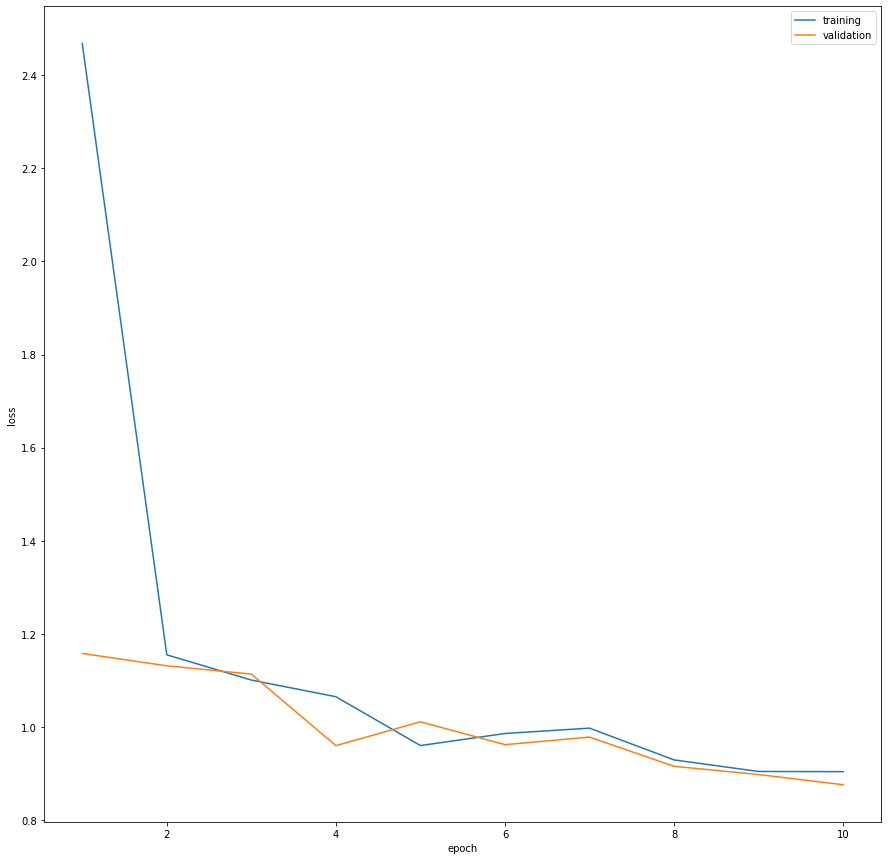

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Getting predictions from test set...


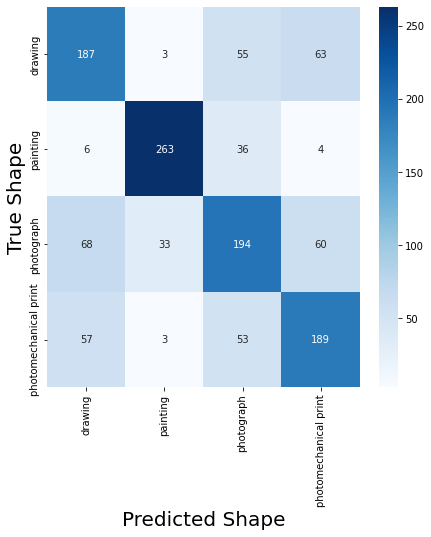

In [ ]:
# Defining Labels and Predictions
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model(data).cpu().data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()